## Regression and Classification with the Ames Housing Data

#### Brief:

There are three components to the project:
1. Estimate the sale price of properties based on their "fixed" characteristics, such as neighborhood, lot size, number of stories, etc.
2. Estimate the value of possible changes and renovations to properties from the variation in sale price not explained by the fixed characteristics. Your goal is to estimate the potential return on investment (and how much you should be willing to pay contractors) when making specific improvements to properties.
3. Determine the features in the housing data that best predict "abnormal" sales (forclosures, etc.).

Before we start tackling the problem, let's first do some exploratory data analysis and see whether the data is fit to work with.

### Exploratory Data Analysis

#### Import Modules:

In [3100]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pprint
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import patsy

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2779]:
df = pd.read_csv('./housing.csv')

In [2780]:
df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


A brief look at the first 5 rows of data shows that this data set needs a lot of work before we can consider building a model around it to predict sales prices. Firstly we can see that there are a lot of missing values, there is an Id feature that will be essentially useless to us, a lot of the features are categorical and some have all 5 rows with values of 0 indicating they might not be useful in modelling but we will get to those later.

Id column to be dropped:

In [2781]:
df = df.drop('Id', axis=1) 

What kind of volume of data are we working with?

In [2782]:
df.shape

(1460, 80)

We have 1460 houses with 80 features, including the SalePrice with which we are aiming to predict and test on. 

The features:

In [2783]:
df.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageCars'

79 features is a lot (minus 1 for Sale Price) and judging by the feature list above, many of these are inter-related, for example the KitchenAbvGr (Kitchen Above Grade) feature would be related to KitchenQual (Kitchen Quality) and can be problematic when creating models due to colinearity and can reduce interpretability when we include too many related features.

#### Understanding the type of data we are working with:

In [2784]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

The features are of 3 types, integer, floats and objects, which are most likely strings and tells you that these are typically categorical features versus numerical continuous variables like square footage.

Which columns are which?

In [2785]:
print df.columns[df.dtypes == object]
print df.columns[df.dtypes == int]
print df.columns[df.dtypes == float]

Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')
Index([u'MSSubClass', u'LotArea', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF',
       u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'H

The features split into categorical and continuous correspond roughly to what we expect from looking at the header of the data earlier. We also have multiple types of integer type features, 1-10 scales for Overall Condition and Quality, Years, Square Footage, Valuations and numbers of a particular feature. 

The features list is not going to be too helpful without the assistance of a description and as such we will consult the data description text file that accompanies this dataset.

#### Data Description

In [2786]:
f = open('./data_description.txt', 'r') 
print f.read()

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

With the assistance of the data description above, we are made aware that MSSubClass should not be in a scale form and for some reason is on a numerical scale from 20-190 with no discernable change in value according to that scale, as such we will need to convert it. 

All other features seem to be represented accurately.

In [2787]:
remap = {20:'OneStory1946New', 30:'OneStory1945Old', 40:'OneStory', 45:'OneHalfStoryUF',
         50:'OneHalfStoryF', 60:'TwoStory1946New', 70:'TwoStory1945Old', 75:'TwoHalfStory',
         80:'SplitMultiLevel', 85:'SplitFoyer', 90:'Duplex', 120:'OneStoryPUD1946New',
         150:'OneHalfStoryPUD', 160:'TwoStoryPUD1946New', 180:'PUDMultiLevel', 190:'TwoFamConv'}

In [2788]:
df.MSSubClass.replace(remap, inplace=True)

After preliminary exploratory data analysis, we need to clean the data to be workable.

## Data Cleaning

The features seem to be named in a convention that is easily understandable, and if in doubt the data description file is easily accessible, however as we will be working with Patsy (A Python package for describing statistical models and for building design matrices) later we do need to rename three features that start with an integer rather than a character.

In [2789]:
df = df.rename(columns={'1stFlrSF': 'FirstFlrSF', '2ndFlrSF': 'SecondFlrSF', '3SsnPorch': 'ThreePorch'})

We need to establish whether the data we are working with is complete with null check:

In [2790]:
df.isnull().sum().sort_values(ascending=False)[0:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

There are 19 features with missing values with four having more than 1000 missing values, which essentially renders them worthless as these features will most likely be poor predictors of sale price given that 80 to over 95% of the houses in the data do not contain these features. Nevertheless these could come in handy later and we have to be careful with dropping these features so early without looking at them further.

#### The Missing Data:
LotFrontage has 259 missing values.

MasVnrType + MasVnrArea have 8 missing values.

Electrical has 1 missing value.

Bsmtexposure and Bsmntfin have 1 missing value.

#### Not Actually Missing Values:
37 houses have no basement.

1365 houses have no alley access.

690 houses have no fireplace.

79 houses have no garage.

1451 houses have no pool.

1176 houses have no fence.

1402 houses have no miscellaneous features.

Upon further inspection and consulting of the data description file, it is evident that the dataset is largely complete with the exception of LotFrontage which has 259 missing values.  The "missing data" in the feature columns with categorical type relating to Alley, Basement, Garage, Fireplace, Fence, Pool, Mason Veneer Type and Miscellaneous Features can all be categorized as having "No Feature" rather than being null and for the numeric features corresponding to these particular features, like GarageArea, the correct value of 0 is already reflected in the columns and does not reflect as missing values. However some features like GarageYrBlt cannot be imputed as 0 or with the mean value.

As such, we can proceed to fill all these particular NA values with a string "None" which will be perfectly usable for categorical transformation for later use in our modelling. We will first fill the missing Electrical with the most common - Sbrkr, which applies to over 90% of the values in Electrical.

In [2791]:
df.loc[df['Electrical'].isnull(),'Electrical'] = 'SBrkr'

In [2792]:
df.Electrical.value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [2793]:
for col in df.columns[df.isnull().sum() > 0]:
    if df[col].dtype == object:
        print df[col].value_counts()
        df[col] = df[col].fillna("None")
        print df[col].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
TA      649
Gd      618
Ex      121
None     37
Fa       35
Name: BsmtQual, dtype: int64
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
TA      1311
Gd        65
Fa        45
None      37
Po         2
Name: BsmtCond, dtype: int64
No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
No      953
Av      221
Gd      134
Mn      114
None     38
Name: BsmtExposure, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
Unf     430
GLQ     418
ALQ     220
BLQ     148
Rec     133
LwQ      74
None     37
Name: BsmtFinType1, dtype: int6

In [2794]:
df.isnull().sum().sort_values(ascending=False)[0:5]

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
SalePrice        0
Foundation       0
dtype: int64

The missing values in GarageYrBlt correspond to the houses with no garage and as it is a feature that is of float type, i.e. we cannot fill with a string "No Feature" like we did with the others. In this case I chose between a few options, to get rid of the feature, or to impute with either the YearBuilt or YearRemodAdd or take the mean of the two to fill.

Let's check how many of the non null GarageYrBlt values match the YearBuilt feature:

In [2795]:
counter = 0
for x in df[df.GarageYrBlt.notnull()][['GarageYrBlt','YearBuilt']].values:
    if x[0] == x[1]:
        counter += 1
print counter

1089


1089 of non null GarageYrBlt values match YearBuilt, whilst it is not over 90% of the values, we can assume that for the vast majority of the cases, YearBuilt will be an accurate value to fill these missing values with.

In [2796]:
df.loc[df['GarageYrBlt'].isnull(), 'GarageYrBlt'] = df[df['GarageYrBlt'].isnull()]['YearBuilt']

In [2797]:
df.isnull().sum().sort_values(ascending=False)[0:3]

LotFrontage    259
MasVnrArea       8
SalePrice        0
dtype: int64

For MsnVnrArea as we filled the 8 corresponding MasVnrType with "None" as per the data description we will fill these with 0.

In [2798]:
df.loc[df['MasVnrArea'].isnull(), 'MasVnrArea'] = 0

In [2799]:
df.isnull().sum().sort_values(ascending=False)[0:5]

LotFrontage    259
SalePrice        0
BsmtQual         0
Exterior1st      0
Exterior2nd      0
dtype: int64

In [2800]:
#Need to double check whether to impute with mean/median

We are left with LotFrontage missing values with which over 10% of the values are missing, imputing these with the mean/median could make it inaccurate as a predictor as such we will fill with mean values but keep it aside as a predictor for the time being and return to it later, if possible imputing those missing values via regression else mean or median.

In [2801]:
df.LotFrontage = df.LotFrontage.fillna(np.mean(df.LotFrontage))

The data is complete and clean.

In [2802]:
df.isnull().sum().sort_values(ascending=False)[0:10]

SalePrice        0
SaleCondition    0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
dtype: int64

### The Target Variable - Sale Price

Having a look at the distribution of the target variable before we proceed with further EDA and more modelling would be apt.

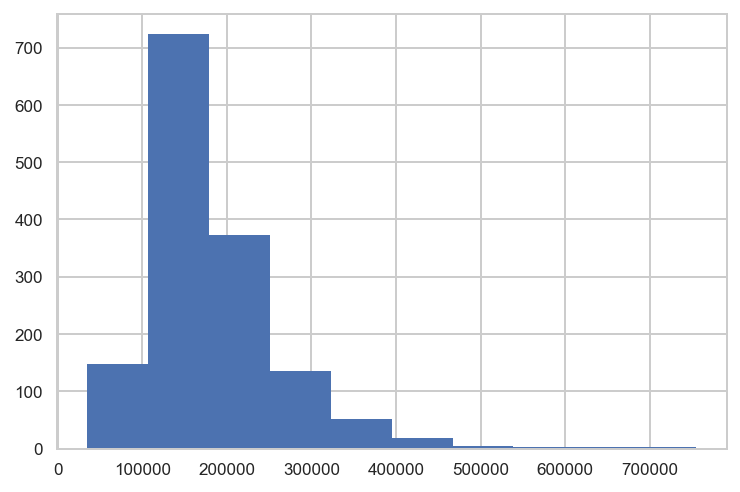

In [2803]:
df.SalePrice.hist();

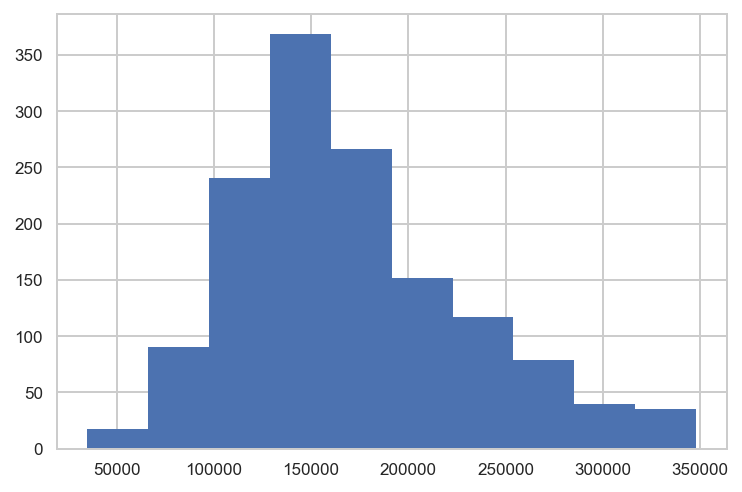

In [2804]:
df.SalePrice[df.SalePrice < 350000].hist();

As the distibution is skewed, it would normally be appropriate to transform it logarithmically but because we want to interpret the coefficients later on for the predictor variables I decided against it.


#### Remove houses with over 4000 Square Feet 

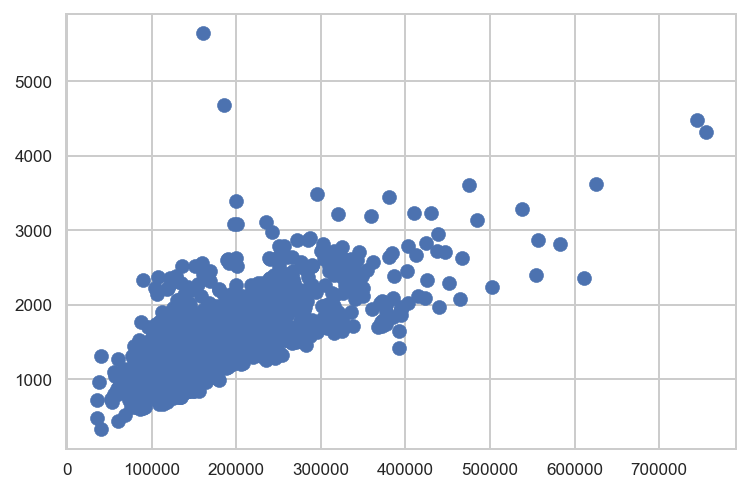

In [2805]:
plt.scatter(df.SalePrice, df.GrLivArea);

The author of the data set recommends removing houses over 4000 square feet as these outliers skew the data and quite clearly the two houses being sold under $200,000 over 4000 sqft seem to be unusually priced relative to the rest of the data points.

In [2806]:
df = df[df.GrLivArea < 4000]

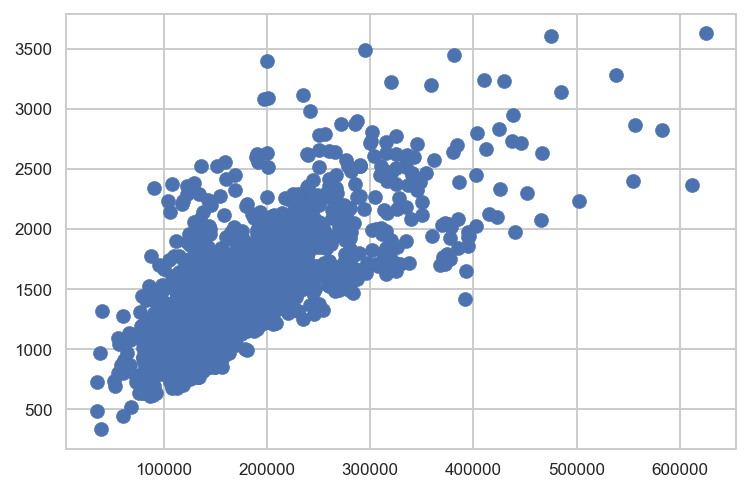

In [2807]:
plt.scatter(df.SalePrice, df.GrLivArea);

#### Remove Houses in Commercial Zoning Areas

As we are looking at only residential properties, we have to get rid of all the houses with commercial zoning.

In [2808]:
df = df[df.MSZoning != 'C (all)']

In [2809]:
df.MSZoning.value_counts()

RL    1147
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [2810]:
#to check
df = df.sort_values('YrSold')

In [2811]:
#to check
df = df.reset_index(drop=True)

Set the target:

In [2812]:
y_test = df[df['YrSold'] >= 2010]['SalePrice']

In [2813]:
y_train = df[df['YrSold'] < 2010]['SalePrice']

# Estimate the sale price of properties based on their "fixed" characteristics, such as neighborhood, lot size, number of stories, etc.

You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
The neighborhood
Square feet
Bedrooms, bathrooms
Basement and garage space
and many more.
Some examples of things that ARE renovate-able:
Roof and exterior features
"Quality" metrics, such as kitchen quality
"Condition" metrics, such as condition of garage
Heating and electrical components
and generally anything you deem can be modified without having to undergo major construction on the house.

Let's first identify which features are fixed. There was a lot of leeway on this but generally, anything that required major construction on the house to be changed was considered a fixed feature.

In [2814]:
fixedchrs = ['SaleCondition', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 
'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtExposure',
'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'BsmtFullBath',
'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreePorch', 'ScreenPorch', 'PoolArea',
'MoSold',  'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','YrSold']

We have to check which of these features are Categorical and which one are numerical.

In [2815]:
fixedcat = []
fixednum = []

In [2816]:
nonfixed = []
for y in df.columns:
    if y not in fixedchrs:
        nonfixed.append(y)

In [2817]:
for y in df[fixedchrs].columns:
    if df[y].dtype == object:
        fixedcat.append(y)
    elif df[y].dtype == float:
        fixednum.append(y)
    else:
        fixednum.append(y)

In [2818]:
print fixedcat

['SaleCondition', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageType']


In [2819]:
print fixednum

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreePorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'YrSold']


Now let's run a correlation matrix to get an idea of what kind of correlation we are working with.

In [2820]:
def create_formula(features):    
    return " ~ " + " + ".join(features) + " + " + "SalePrice" + "-1"

In [2821]:
testallfixed = create_formula(fixedchrs)

In [2822]:
testallfixed

' ~ SaleCondition + MSSubClass + MSZoning + LotFrontage + LotArea + Street + Alley + LotShape + LandContour + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + YearBuilt + YearRemodAdd + Foundation + BsmtQual + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + TotalBsmtSF + FirstFlrSF + SecondFlrSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + Fireplaces + GarageType + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreePorch + ScreenPorch + PoolArea + MoSold + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + YrSold + SalePrice-1'

#### Correlation Matrix

In [2823]:
X_corr = patsy.dmatrix(testallfixed, data=dftr, return_type='dataframe')

In [2824]:
corr = X_corr.corr()

In [2825]:
X_corr.corr().sort_values('SalePrice', ascending=False)[0:20]['SalePrice']

SalePrice                        1.000000
GrLivArea                        0.721900
GarageCars                       0.652681
GarageArea                       0.647466
TotalBsmtSF                      0.640482
FirstFlrSF                       0.620258
FullBath                         0.561060
TotRmsAbvGrd                     0.532907
YearBuilt                        0.526146
YearRemodAdd                     0.522464
GarageYrBlt                      0.517690
Foundation[T.PConc]              0.491478
Fireplaces                       0.468234
Neighborhood[T.NridgHt]          0.428953
MSSubClass[T.TwoStory1946New]    0.381037
BsmtFinSF1                       0.375941
SaleCondition[Partial]           0.371837
LotFrontage                      0.353083
OpenPorchSF                      0.352506
GarageType[T.Attchd]             0.335305
Name: SalePrice, dtype: float64

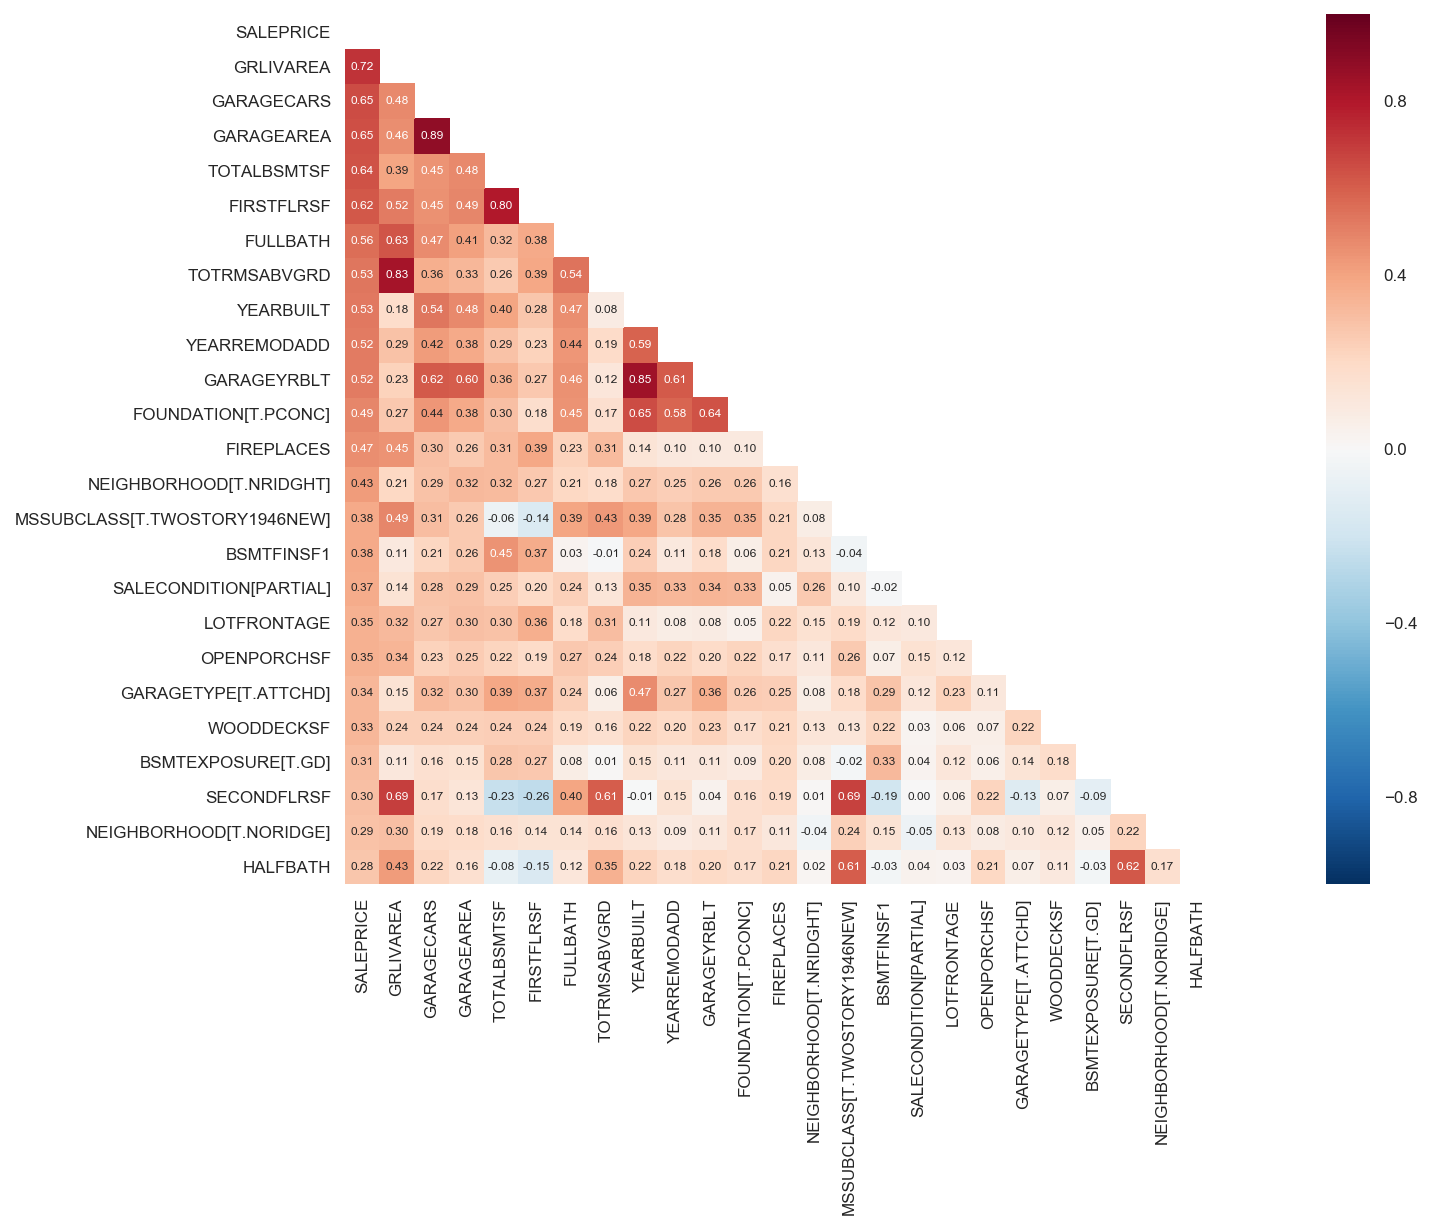

In [2826]:
fig, ax = plt.subplots(figsize=(20,8))
cols = corr.nlargest(25, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(X_corr[cols].values.T)
sns.set(font_scale=0.85)
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(cm, cbar=True, annot=True, mask=mask, square=True, annot_kws={'size': 6}, fmt='.2f', yticklabels=map(lambda x: x.upper(), cols.values), xticklabels=map(lambda x: x.upper(), cols.values))
plt.show()

Judging by this correlation matrix of the top 25 correlated predictors out of all fixed characteristic features, we have a few which are quite strongly correlated to price like GrLivArea or Ground Living Area as well as Garage Area and Basement Square Footage. However as we notice also in the correlation matrix, many of these are colinear, for example Garage Area would be directly correlated to Garage Cars for example but many of these colinear features aren't as obvious and we have to be careful about them, which is why it would be prudent to approach the model from using a Ridge Regression to penalize the coefficients of the large number of variables we are working with. 

Before we try out a ridge regression with our fixed characteristic features, let's try a simple multi-feature linear regression with all fixed features, then a smaller number of features chosen by 'hand' or with supervision that I assume will have lower than average colinearity.

### Regression with all fixed features:

In [2827]:
x_fixformula = " ~ "+"+".join(fixednum)+"+".join(["C("+x+")" for x in fixedcat])

In [2828]:
x_fixformula

' ~ LotFrontage+LotArea+YearBuilt+YearRemodAdd+BsmtFinSF1+BsmtFinSF2+TotalBsmtSF+FirstFlrSF+SecondFlrSF+GrLivArea+BsmtFullBath+BsmtHalfBath+FullBath+HalfBath+Fireplaces+GarageYrBlt+GarageCars+GarageArea+WoodDeckSF+OpenPorchSF+EnclosedPorch+ThreePorch+ScreenPorch+PoolArea+MoSold+BedroomAbvGr+KitchenAbvGr+TotRmsAbvGrd+YrSoldC(SaleCondition)+C(MSSubClass)+C(MSZoning)+C(Street)+C(Alley)+C(LotShape)+C(LandContour)+C(LotConfig)+C(LandSlope)+C(Neighborhood)+C(Condition1)+C(Condition2)+C(BldgType)+C(HouseStyle)+C(Foundation)+C(BsmtQual)+C(BsmtExposure)+C(GarageType)'

In [2829]:
fixall = ' ~ LotFrontage+LotArea+YearBuilt+YearRemodAdd+BsmtFinSF1+BsmtFinSF2+TotalBsmtSF+FirstFlrSF+SecondFlrSF+GrLivArea+BsmtFullBath+BsmtHalfBath+FullBath+HalfBath+Fireplaces+GarageYrBlt+GarageCars+GarageArea+WoodDeckSF+OpenPorchSF+EnclosedPorch+ThreePorch+ScreenPorch+PoolArea+MoSold+BedroomAbvGr+KitchenAbvGr+TotRmsAbvGrd+YrSold+C(SaleCondition)+C(MSSubClass)+C(MSZoning)+C(Street)+C(Alley)+C(LotShape)+C(LandContour)+C(LotConfig)+C(LandSlope)+C(Neighborhood)+C(Condition1)+C(Condition2)+C(BldgType)+C(HouseStyle)+C(Foundation)+C(BsmtQual)+C(BsmtExposure)+C(GarageType)-1'

In [2830]:
# fixall = create_formula2(fixedchrs)

In [2831]:
X = patsy.dmatrix(fixall, data=df, return_type='dataframe')

In [2832]:
X_tr = X[X['YrSold'] < 2010]
X_te = X[X['YrSold'] >= 2010]

In [2833]:
X_tr = X_tr.reset_index(drop=True)
X_te = X_te.reset_index(drop=True)

#### Standardizing the features:

For use with our model we need to be standardizing the features.

In [2834]:
nonstdcols = [col for col in X_tr.columns if col.startswith('C')]

In [2835]:
stdcols = [col for col in X_tr.columns if col in fixednum]

In [2836]:
len(nonstdcols)

107

In [2837]:
len(stdcols)

29

In [2838]:
print len(X_tr.columns)
print 29+107

136
136


In [2839]:
standard = StandardScaler()
standard.fit(X_tr[stdcols])
X_std = pd.DataFrame(standard.transform(X_tr[stdcols]),columns=stdcols)
X_nonstd = X_tr[nonstdcols]

In [2840]:
print X_std.shape
X_std.head(1)

(1274, 29)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,FirstFlrSF,SecondFlrSF,GrLivArea,...,OpenPorchSF,EnclosedPorch,ThreePorch,ScreenPorch,PoolArea,MoSold,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,YrSold
0,-0.216316,-0.324241,0.67825,0.34354,-0.112997,-0.285582,-0.705669,-0.947229,1.030988,0.184196,...,1.164408,-0.34885,-0.118686,-0.270429,-0.062143,0.153731,0.164513,-0.205396,0.304867,-1.349392


In [2841]:
print X_nonstd.shape
X_nonstd.head(1)

(1274, 107)


,C(SaleCondition)[Abnorml],C(SaleCondition)[AdjLand],C(SaleCondition)[Alloca],C(SaleCondition)[Family],C(SaleCondition)[Normal],C(SaleCondition)[Partial],C(MSSubClass)[T.OneHalfStoryF],C(MSSubClass)[T.OneHalfStoryUF],C(MSSubClass)[T.OneStory],C(MSSubClass)[T.OneStory1945Old],...,C(BsmtExposure)[T.Gd],C(BsmtExposure)[T.Mn],C(BsmtExposure)[T.No],C(BsmtExposure)[T.None],C(GarageType)[T.Attchd],C(GarageType)[T.Basment],C(GarageType)[T.BuiltIn],C(GarageType)[T.CarPort],C(GarageType)[T.Detchd],C(GarageType)[T.None]
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [2842]:
Xfix_tr = X_std.combine_first(X_nonstd)

In [2843]:
Xfix_tr.head(1)

,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,C(Alley)[T.None],C(Alley)[T.Pave],C(BldgType)[T.2fmCon],C(BldgType)[T.Duplex],C(BldgType)[T.TwnhsE],...,PoolArea,ScreenPorch,SecondFlrSF,ThreePorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,0.164513,-0.112997,-0.285582,-0.801908,-0.250446,1.0,0.0,0.0,0.0,0.0,...,-0.062143,-0.270429,1.030988,-0.118686,0.304867,-0.705669,-0.753853,0.67825,0.34354,-1.349392


In [2844]:
standard.fit(X_te[stdcols])
X_std_te = pd.DataFrame(standard.transform(X_te[stdcols]),columns=stdcols)
X_nonstd_te = X_te[nonstdcols]

In [2845]:
Xfix_te = X_std_te.combine_first(X_nonstd_te)

In [2846]:
Xfix_te.head(1)

,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,C(Alley)[T.None],C(Alley)[T.Pave],C(BldgType)[T.2fmCon],C(BldgType)[T.Duplex],C(BldgType)[T.TwnhsE],...,PoolArea,ScreenPorch,SecondFlrSF,ThreePorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,0.137569,0.170007,-0.326069,0.923649,-0.133235,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.273834,1.262869,-0.105288,0.297029,-0.589117,-0.754544,1.005593,0.712169,0.0


In [2847]:
def error_print(name,model_,X_train_,y_train_,predictions_train_,X_test_,y_test_,predictions_test_):

    """Returns r^2, RMSE and MAE for the test set;
    prints r^2, RMSE and MAE for training and test sets;
    arguments: the model's name and six lists: 
    1. the training set feature matrix, 2. the training set response, 
    3. the training set response predictions, 4. the test set feature matrix, 
    5. the test set response, 6. the test set response predictions.
    """
    
    print "Training", name 
    print "r^2:", model.score(X_train_, y_train_)
    print "RMSE:", mean_squared_error(y_train_, predictions_train_)
    print "MAE:", mean_absolute_error(y_train_, predictions_train_)
    
    print 
    
    print "Test", name

    print "r^2:", model.score(X_test_, y_test_)
    print "RMSE:", mean_squared_error(y_test_, predictions_test_)
    print "MAE:", mean_absolute_error(y_test_, predictions_test_)
    print "Coefficients:", model.coef_, model.intercept_
    print 
    return [ model.score(X_test_, y_test_),
                       mean_squared_error(y_test_, predictions_test_),
                       mean_absolute_error(y_test_, predictions_test_)]

In [2848]:
Xfix_tr.shape

(1274, 136)

In [2849]:
error_dict = {}
# Fit a straight line to the data
lm = linear_model.LinearRegression()
model = lm.fit(Xfix_tr, y_train)
predictions_train = model.predict(Xfix_tr)
predictions_test = model.predict(Xfix_te)
error_dict['all'] = error_print('all',model,Xfix_tr,y_train,predictions_train,Xfix_te,y_test,predictions_test)

# errors_all = pd.DataFrame(error_dict,index=['r^2','RMSE','MAE'])
# errors_all


Training all
r^2: 0.908658656167
RMSE: 526409131.138
MAE: 16072.0941915

Test all
r^2: 0.897211254104
RMSE: 653469080.872
MAE: 17422.2790698
Coefficients: [ -5.97139552e+03   7.58668009e+03   7.47765316e+01   7.77601737e+02
  -3.83390625e+02   1.68962532e+03   1.57211582e+02  -1.43845806e+04
   2.04334545e+16  -1.14987500e+03  -3.70800000e+03   1.81165000e+04
  -1.35662500e+03  -6.35754688e+03  -1.65836562e+04  -2.46561848e+04
  -3.18540000e+04   7.71553125e+03  -2.67837500e+04  -3.13250000e+03
   4.86137500e+03   7.67087500e+03   4.30600000e+03  -2.44431250e+04
  -2.19194727e+03   2.06520312e+03   5.76828125e+02  -2.72068750e+03
  -2.58581250e+03   8.36699375e+04  -7.53434863e+03  -5.09464688e+04
  -8.85832812e+03   2.87850000e+03  -1.88025000e+03   2.22131250e+03
  -5.05568750e+03   6.81225000e+03  -2.37477500e+04   1.99268516e+04
   2.08238750e+04   2.79831250e+04  -2.48600000e+03   2.33242500e+04
   2.87868750e+04   1.19623750e+04   2.34575000e+03  -7.73375000e+02
  -1.06733750e+04

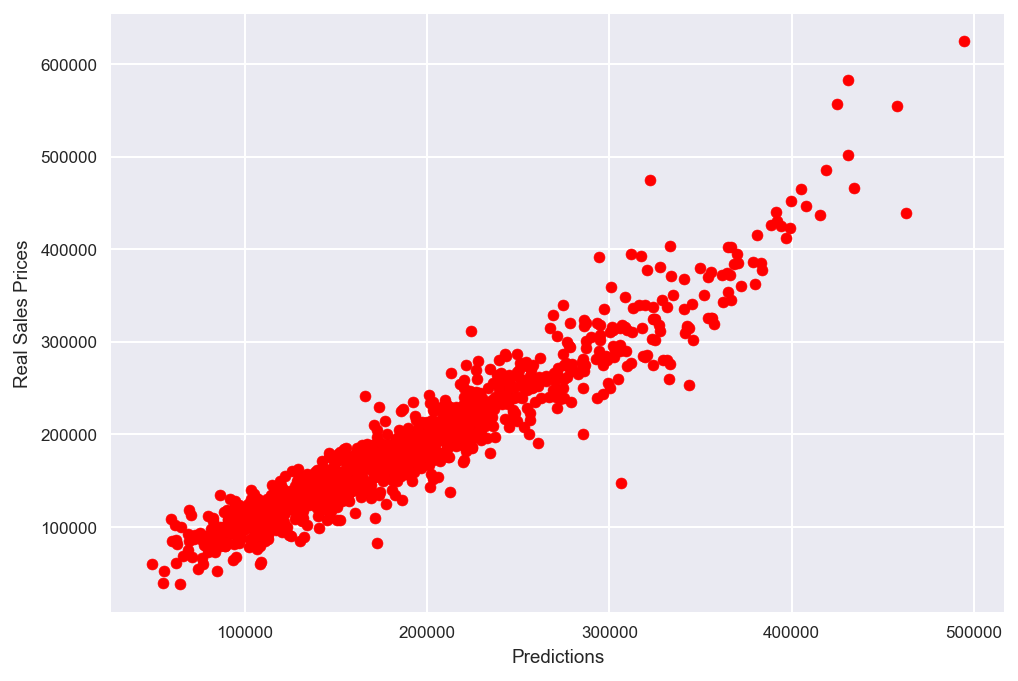

In [2850]:
plt.scatter(predictions_train, y_train, s=30, c='r', zorder=10)
plt.xlabel("Predictions")
plt.ylabel("Real Sales Prices")
plt.show()

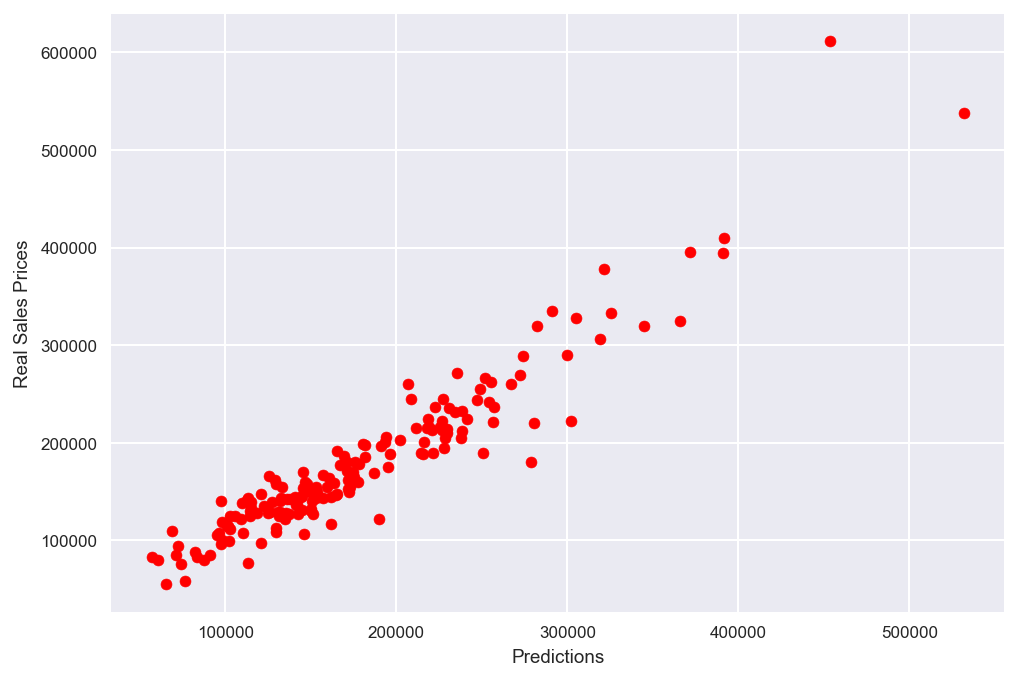

In [2851]:
plt.scatter(predictions_test, y_test, s=30, c='r', zorder=10)
plt.xlabel("Predictions")
plt.ylabel("Real Sales Prices")
plt.show()

In [2852]:
#Print the features + their coefficients
# for f, c in zip(featurenames, lm.coef_):
#     print f, c

The model with all the fixed features isn't very useful from the standpoint of the client as it is overfitting, accounting for 40+ features, although it predicts about 90% of the variance in the sales price, we can reduce the amount of fixed characteristics and still explain a lot of the Sale Price which will be much more useful from the standpoint of the client.

I've chosen a few variables based on the correlation matrix, the features and their coefficients above as well to reliably estimate the house prices based on this subset of fixed characteristics. As I have already filtered my features by a subset (see below) using my assumptions and am not looking to reduce any coefficient to 0 but penalize colinearity which I have already accounted for in my choice of features, I decided on the ridge regression.

In [2854]:
Xfix_tr_subset_form = '~ GrLivArea+GarageArea+TotRmsAbvGrd+TotalBsmtSF+FirstFlrSF+FullBath+YearRemodAdd+GarageYrBlt+Foundation+Fireplaces+Neighborhood+MSSubClass+SaleCondition+LotFrontage+OpenPorchSF+WoodDeckSF+YrSold-1'

In [2855]:
Xfix_tr_subset_cols = ['GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FirstFlrSF',
  'FullBath', 'YearBuilt', 'TotRmsAbvGrd', 'YearRemodAdd', 'GarageYrBlt', 'C(Foundation)[T.CBlock]',
  'C(Foundation)[T.PConc]', 'C(Foundation)[T.Slab]', 'C(Foundation)[T.Stone]', 'C(Foundation)[T.Wood]',
  'C(Neighborhood)[T.Blueste]', 'Fireplaces', 'C(Neighborhood)[T.BrDale]',
  'C(Neighborhood)[T.BrkSide]', 'C(Neighborhood)[T.ClearCr]', 'C(Neighborhood)[T.CollgCr]',
  'C(Neighborhood)[T.Crawfor]', 'C(Neighborhood)[T.Edwards]', 'C(Neighborhood)[T.Gilbert]',
  'C(Neighborhood)[T.IDOTRR]', 'C(Neighborhood)[T.MeadowV]', 'C(Neighborhood)[T.Mitchel]',
  'C(Neighborhood)[T.NAmes]', 'C(Neighborhood)[T.NPkVill]', 'C(Neighborhood)[T.NWAmes]',
  'C(Neighborhood)[T.NoRidge]', 'C(Neighborhood)[T.NridgHt]', 'C(Neighborhood)[T.OldTown]',
  'C(Neighborhood)[T.SWISU]', 'C(Neighborhood)[T.SawyerW]', 'C(Neighborhood)[T.Sawyer]',
  'C(Neighborhood)[T.Somerst]', 'C(Neighborhood)[T.StoneBr]', 'C(Neighborhood)[T.Timber]',
  'C(Neighborhood)[T.Veenker]', 'C(MSSubClass)[T.OneHalfStoryF]', 'C(MSSubClass)[T.OneHalfStoryUF]', 'C(MSSubClass)[T.OneStory1945Old]',
  'C(MSSubClass)[T.OneStory1946New]', 'C(MSSubClass)[T.OneStoryPUD1946New]', 'C(MSSubClass)[T.OneStory]', 'C(MSSubClass)[T.PUDMultiLevel]',
  'C(MSSubClass)[T.SplitFoyer]', 'C(MSSubClass)[T.SplitMultiLevel]', 'C(MSSubClass)[T.TwoFamConv]', 'C(MSSubClass)[T.TwoHalfStory]', 'C(MSSubClass)[T.TwoStory1945Old]',
  'C(MSSubClass)[T.TwoStory1946New]', 'C(MSSubClass)[T.TwoStoryPUD1946New]', 'C(SaleCondition)[Abnorml]', 'C(SaleCondition)[AdjLand]', 'C(SaleCondition)[Alloca]', 'C(SaleCondition)[Family]', 'C(SaleCondition)[Normal]',
  'C(SaleCondition)[Partial]', 'OpenPorchSF', 'WoodDeckSF'
]

In [2856]:
Xfix_tr_subset = Xfix_tr[Xfix_tr_subset_cols]
Xfix_te_subset = Xfix_te[Xfix_tr_subset_cols]

In [2857]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()


# Setup search parameters
search_parameters = {
#    "alpha": np.linspace(10**(-10), 0.5, 1001)
    "alpha": np.logspace(-10, 10, 101)
}

estimator = GridSearchCV(ridge, search_parameters)
results = estimator.fit(Xfix_tr_subset, y_train)
print "Best estimator:"
print results.best_estimator_

print 

print "Best score:"
print results.best_score_

print

print "Best params:"
print results.best_params_

print 

print "Grid parameters"
print results.param_grid

print 
df_score = pd.DataFrame(results.cv_results_)
df_score.sort_values(by='rank_test_score').head()

Best estimator:
Ridge(alpha=2.5118864315095824, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Best score:
0.840267680844

Best params:
{'alpha': 2.5118864315095824}

Grid parameters
{'alpha': array([  1.00000000e-10,   1.58489319e-10,   2.51188643e-10,
         3.98107171e-10,   6.30957344e-10,   1.00000000e-09,
         1.58489319e-09,   2.51188643e-09,   3.98107171e-09,
         6.30957344e-09,   1.00000000e-08,   1.58489319e-08,
         2.51188643e-08,   3.98107171e-08,   6.30957344e-08,
         1.00000000e-07,   1.58489319e-07,   2.51188643e-07,
         3.98107171e-07,   6.30957344e-07,   1.00000000e-06,
         1.58489319e-06,   2.51188643e-06,   3.98107171e-06,
         6.30957344e-06,   1.00000000e-05,   1.58489319e-05,
         2.51188643e-05,   3.98107171e-05,   6.30957344e-05,
         1.00000000e-04,   1.58489319e-04,   2.51188643e-04,
         3.98107171e-04,   6.30957344e-04,   1.00000000e-03,
     

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
52,0.004743,0.000401,0.840268,0.860858,2.51189,{u'alpha': 2.51188643151},1,0.840292,0.860185,0.843161,0.858995,0.837343,0.863393,0.002523,0.000056,0.002375,0.001857
53,0.002684,0.001537,0.840091,0.859502,3.98107,{u'alpha': 3.98107170553},2,0.838893,0.858824,0.844219,0.857676,0.837154,0.862007,0.000049,0.001684,0.003006,0.001832
51,0.005144,0.000416,0.840052,0.861732,1.58489,{u'alpha': 1.58489319246},3,0.840965,0.861201,0.841944,0.859772,0.837240,0.864223,0.002618,0.000037,0.002026,0.001856
50,0.003363,0.000423,0.839631,0.862308,1,{u'alpha': 1.0},4,0.841038,0.862007,0.840799,0.860209,0.837049,0.864707,0.000901,0.000085,0.001826,0.001848
54,0.004769,0.000398,0.839250,0.857417,6.30957,{u'alpha': 6.3095734448},5,0.836615,0.856894,0.844773,0.855563,0.836354,0.859795,0.002678,0.000051,0.003909,0.001767


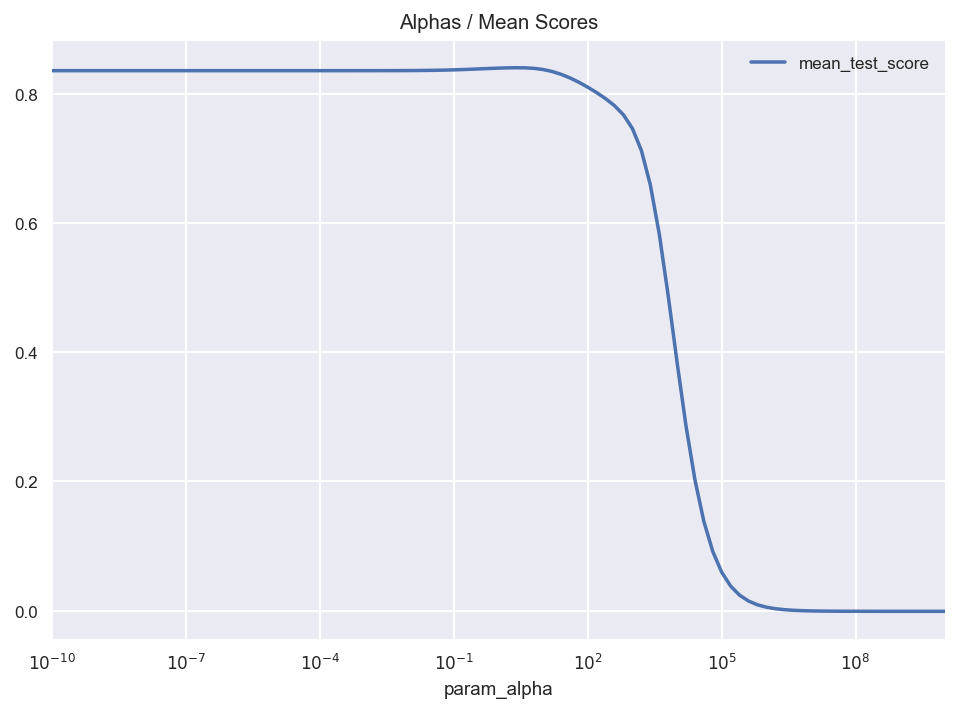

In [2858]:
df_score.plot( x="param_alpha", y="mean_test_score", title="Alphas / Mean Scores")
plt.xscale('log')
plt.show()

In [2859]:
coefs = []

for alpha in df_score.param_alpha:
    
    # Initialize Lasso model with alpha parameter
    ridge = Ridge(alpha=alpha)
    model = ridge.fit(Xfix_tr_subset, y_train)
    
    # Append coeficients to new object for later review
    alpha_coefs_r = {key: value for key, value in zip(Xfix_tr_subset.columns, model.coef_.flatten())}
    alpha_coefs_r.update({"alpha": alpha}) # include alpha in list
    
    coefs.append(alpha_coefs_r)

In [2860]:
print "Best Alpha was: ", results.best_params_

# Coefs change with parameter alpha
df_coef = pd.DataFrame([c.values() for c in coefs],columns=coefs[0].keys())

df_coef['alpha'] = df_coef['alpha'].round(3)
df_coef.set_index('alpha',inplace=True)
df_coef.head(10)

Best Alpha was:  {'alpha': 2.5118864315095824}


,C(MSSubClass)[T.OneHalfStoryF],C(Neighborhood)[T.Crawfor],C(MSSubClass)[T.OneHalfStoryUF],C(Neighborhood)[T.NridgHt],GarageYrBlt,C(Neighborhood)[T.NWAmes],C(SaleCondition)[AdjLand],C(Foundation)[T.Slab],C(Neighborhood)[T.NoRidge],C(MSSubClass)[T.OneStory1946New],...,C(Neighborhood)[T.Gilbert],C(SaleCondition)[Family],C(Neighborhood)[T.Timber],C(MSSubClass)[T.TwoFamConv],C(Foundation)[T.Stone],C(Neighborhood)[T.Veenker],C(Neighborhood)[T.BrDale],C(Neighborhood)[T.CollgCr],C(MSSubClass)[T.SplitMultiLevel],C(Neighborhood)[T.ClearCr]
alpha,,,,,,,,,,,,,,,,,,,,,
0.0,21306.775226,29733.912888,34902.398457,52452.300589,-1890.748702,-7731.863847,21394.301872,15995.850303,37321.384313,24436.574200,...,-8166.206349,-16720.105141,13359.798626,16131.951233,-6439.344976,34930.612354,24601.702612,-3005.978513,30233.380077,679.840508
0.0,21306.775225,29733.912886,34902.398456,52452.300588,-1890.748702,-7731.863848,21396.802381,15995.850303,37321.384312,24436.574200,...,-8166.206350,-16717.604631,13359.798625,16131.951232,-6439.344976,34930.612353,24601.702610,-3005.978514,30233.380077,679.840507
0.0,21306.775224,29733.912884,34902.398455,52452.300586,-1890.748702,-7731.863850,21408.347382,15995.850302,37321.384310,24436.574199,...,-8166.206352,-16706.059629,13359.798623,16131.951231,-6439.344976,34930.612351,24601.702608,-3005.978516,30233.380076,679.840505
0.0,21306.775222,29733.912881,34902.398453,52452.300583,-1890.748702,-7731.863853,21408.286351,15995.850301,37321.384307,24436.574197,...,-8166.206355,-16706.120658,13359.798620,16131.951229,-6439.344976,34930.612347,24601.702605,-3005.978519,30233.380074,679.840502
0.0,21306.775219,29733.912876,34902.398449,52452.300579,-1890.748702,-7731.863858,21411.251045,15995.850300,37321.384301,24436.574195,...,-8166.206360,-16703.155962,13359.798614,16131.951226,-6439.344976,34930.612341,24601.702599,-3005.978524,30233.380072,679.840496
0.0,21306.775215,29733.912867,34902.398443,52452.300571,-1890.748702,-7731.863866,21412.241279,15995.850298,37321.384293,24436.574191,...,-8166.206368,-16702.165724,13359.798606,16131.951221,-6439.344976,34930.612333,24601.702590,-3005.978532,30233.380068,679.840488
0.0,21306.775207,29733.912854,34902.398434,52452.300559,-1890.748702,-7731.863879,21413.372829,15995.850295,37321.384280,24436.574185,...,-8166.206380,-16701.034167,13359.798594,16131.951213,-6439.344975,34930.612318,24601.702576,-3005.978544,30233.380061,679.840475
0.0,21306.775195,29733.912833,34902.398419,52452.300540,-1890.748702,-7731.863899,21413.872920,15995.850290,37321.384258,24436.574176,...,-8166.206400,-16700.534065,13359.798574,16131.951201,-6439.344974,34930.612296,24601.702553,-3005.978563,30233.380051,679.840455
0.0,21306.775176,29733.912800,34902.398396,52452.300511,-1890.748703,-7731.863930,21413.828064,15995.850282,37321.384225,24436.574161,...,-8166.206430,-16700.578905,13359.798542,16131.951182,-6439.344973,34930.612260,24601.702517,-3005.978594,30233.380035,679.840423


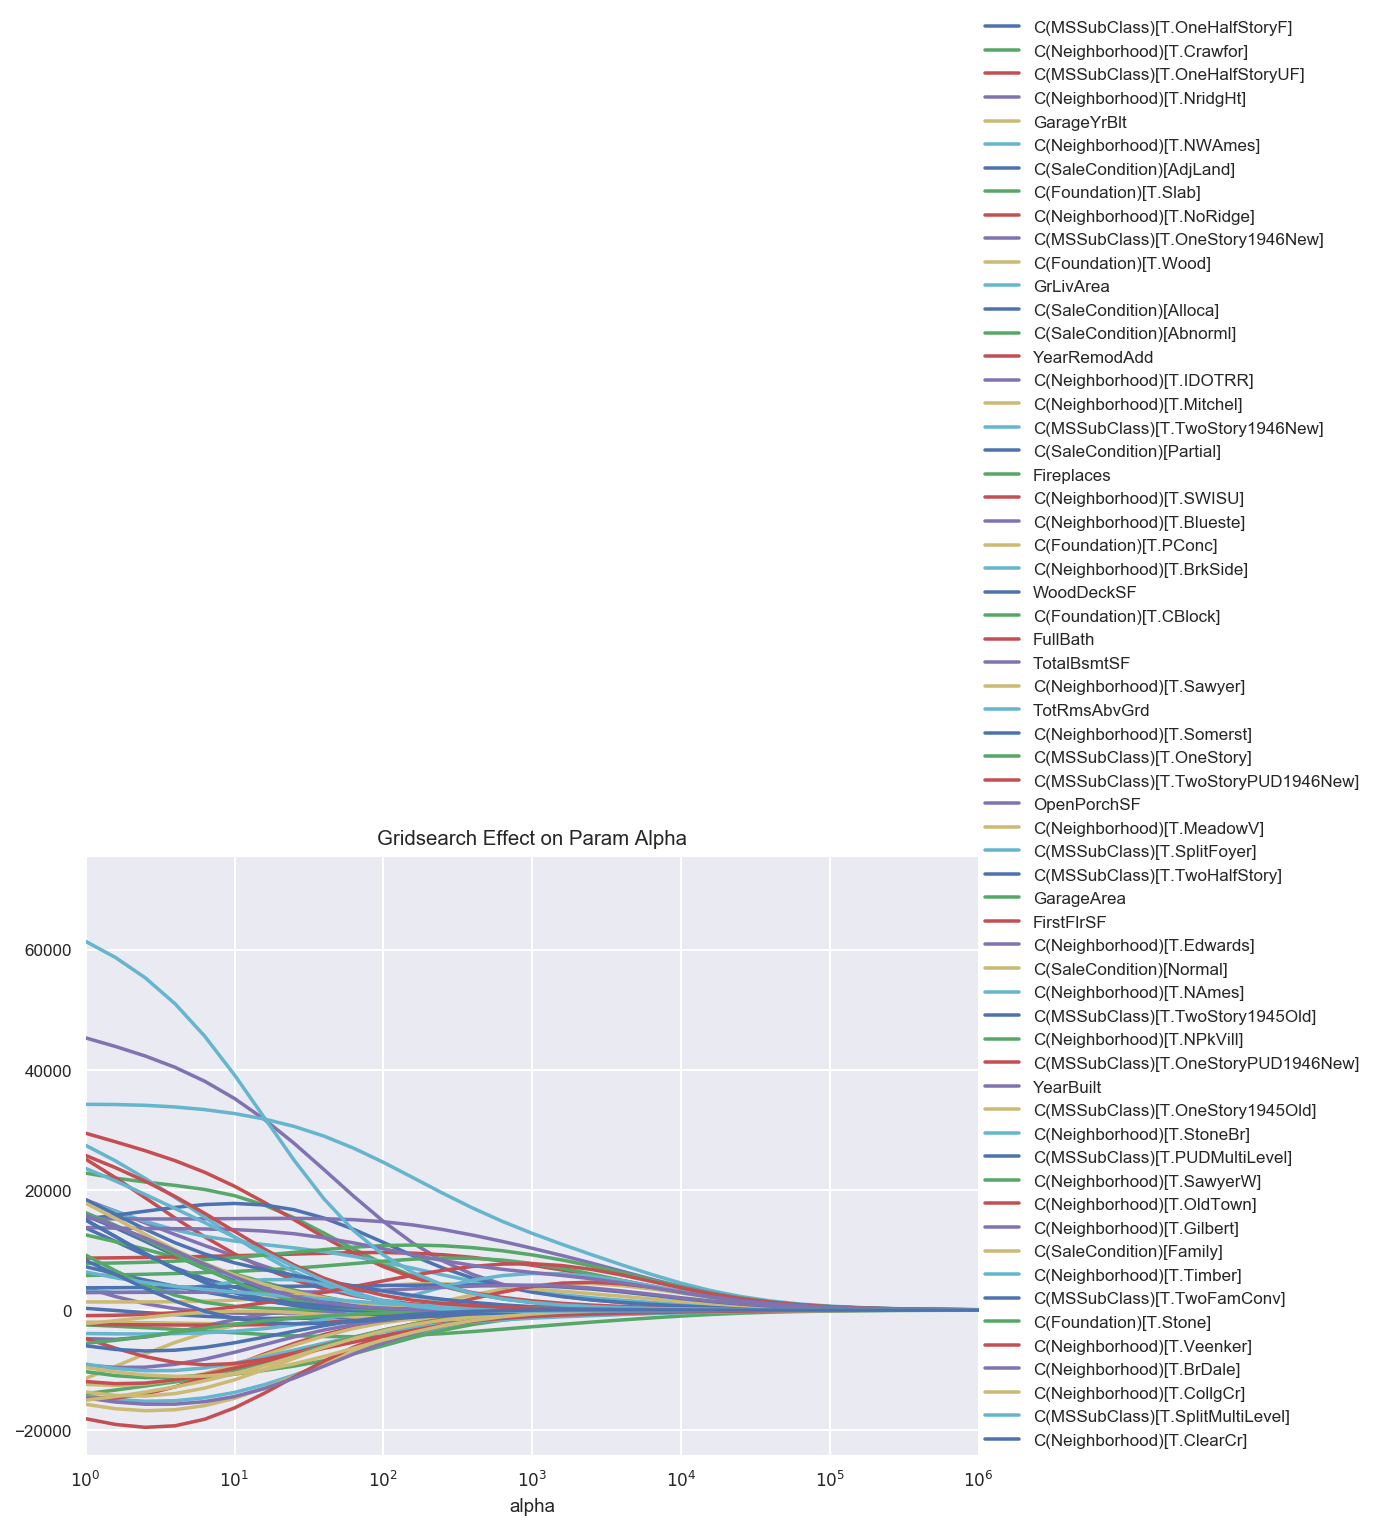

In [2861]:
df_coef.plot(title="Gridsearch Effect on Param Alpha")
plt.xscale('log')
plt.xlim([10**(0),10**(6)])
plt.legend(loc=[1,0])
plt.show()

In [2862]:
predictions_tr_sub = results.best_estimator_.predict(Xfix_tr_subset)
predictions_te_sub = results.best_estimator_.predict(Xfix_te_subset)

In [2863]:
print results.best_score_
print results.best_estimator_

0.840267680844
Ridge(alpha=2.5118864315095824, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)


With an alpha of 2.511, the model predicts 0.84 or 84% of the variation in sale price with just Above Ground Living Area, Garage Area, Total Basement Squart Footage, First Floor Squart Footage, Year Remodeled, Garage Year Built, Foundation, Neighborhood, MS Sub Class, Sale Condition and with Deck and Porch Square Footage. This is a satisfactory number as we have substantially reduced the number of fixed features and reduced overfitting seriously and still have managed to explain 84% of the variation in Sale Price.

Let's take a look at the coefficients we are working with:

In [2864]:
 for f, c in zip(Xfix_tr_subset.columns, results.best_estimator_.coef_):
     print f, c

GrLivArea 34079.7835443
GarageArea 7963.98794662
TotalBsmtSF 15168.0968203
FirstFlrSF -703.831239477
FullBath -2449.81772559
YearBuilt 13586.4273362
TotRmsAbvGrd -3965.02995521
YearRemodAdd 8768.96405977
GarageYrBlt -2093.84472367
C(Foundation)[T.CBlock] -2922.7229223
C(Foundation)[T.PConc] 1368.69812507
C(Foundation)[T.Slab] 10123.4622397
C(Foundation)[T.Stone] -4412.05829247
C(Foundation)[T.Wood] -7280.09589726
C(Neighborhood)[T.Blueste] 1073.0897884
Fireplaces 5966.23401593
C(Neighborhood)[T.BrDale] 12001.7671223
C(Neighborhood)[T.BrkSide] 3019.61525031
C(Neighborhood)[T.ClearCr] -6798.09770545
C(Neighborhood)[T.CollgCr] -10802.6443967
C(Neighborhood)[T.Crawfor] 21317.9196608
C(Neighborhood)[T.Edwards] -9494.40325145
C(Neighborhood)[T.Gilbert] -15652.1364381
C(Neighborhood)[T.IDOTRR] -4483.88614944
C(Neighborhood)[T.MeadowV] -12295.481341
C(Neighborhood)[T.Mitchel] -16734.3539552
C(Neighborhood)[T.NAmes] -10084.011902
C(Neighborhood)[T.NPkVill] 11803.7934281
C(Neighborhood)[T.NWAmes

As you can see the coefficients above are monetary values which correspond to a movement in a standard deviation of the non-categorical feature and to whether a categorical feature is available or not, as such here are the most important takeaways from the model:

Partial Sale Condition correspond to the most increase in value of all houses as it is associated with new homes.
The bigger the porch the higher the value, wood decks are better than regular porches.
Split Foyer houses are the best class of dwelling.
Stone Brook is the best neighborhood for increase in Sale Price even though there are other neighborhoods have higher Sale Prices overall.
Slab is the best foundation for houses.
The newer the house, the higher the value, Year Built is most important out of YearRemodAdd,GarageYrBlt, more value is gained from having a newer Garage than if the Garage was built when the house was originally built.
Fireplaces add almost 6000 in value each.
Basement and Above Ground Living Area add much more value to houses than First Floor Square Footage.

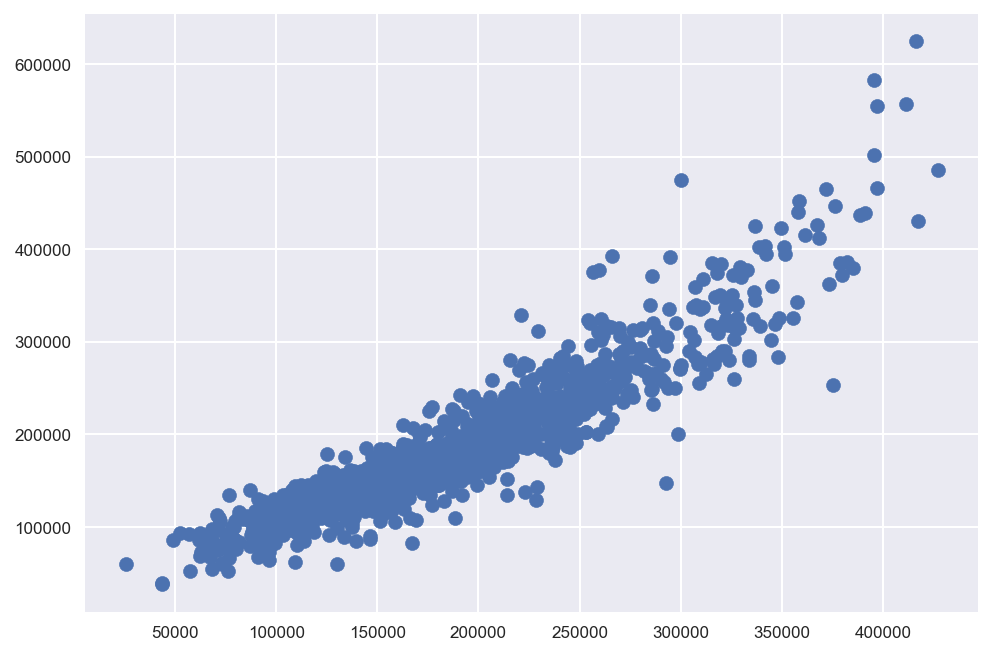

In [2865]:
plt.scatter(predictions_tr_sub, y_train)
plt.show()

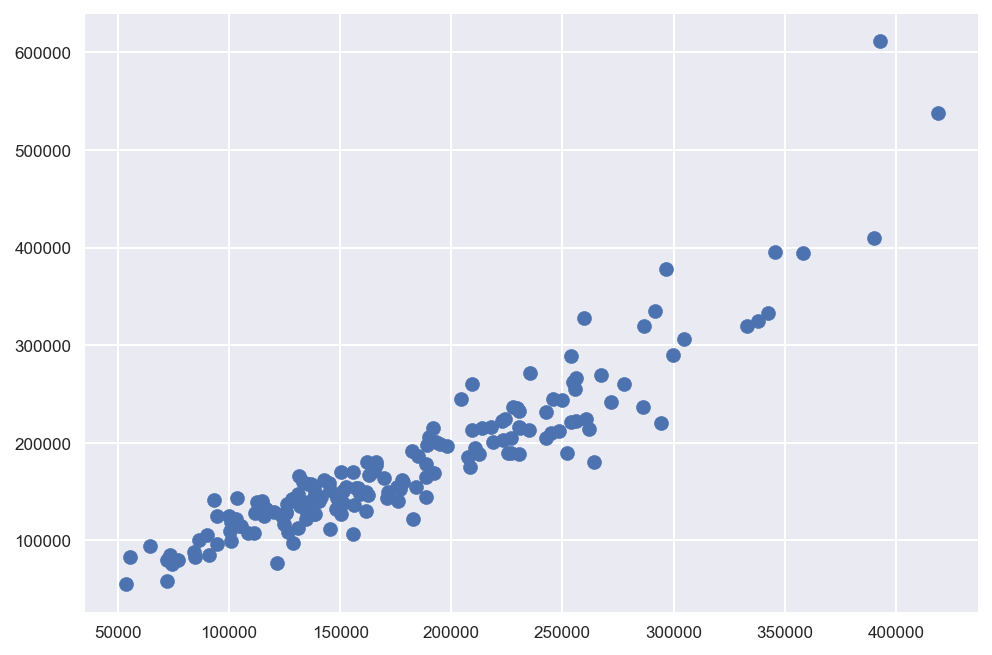

In [2866]:
plt.scatter(predictions_te_sub, y_test)

Mean Sale Price in our Test Set vs. our Test Predictions

In [2867]:
dfte.SalePrice.mean()

179167.0

In [2868]:
predictions_te_sub.mean()

179376.65647168961

Generally the model approximates the y_test pretty accurately.

### Variance in the Residuals - How much of the variance can we explain by renovatable features?

Now let's create our residuals to approximate the value of renovating features and how much difference that they would create. As the number of features that are renovatable are relatively small in comparison to fixed, we can stick with keeping them all as we require as many features as possible to understand the variance in the residuals, we have already lost 5% 

In [2869]:
df.loc[df['YrSold'] < 2010, 'Residuals'] = df.loc[df['YrSold'] < 2010, 'SalePrice'] - predictions_tr_sub

In [2870]:
df.loc[df['YrSold'] >=2010, 'Residuals'] = df.loc[df['YrSold'] >= 2010, 'SalePrice'] - predictions_te_sub

In [2871]:
y_train_res = df[df['YrSold'] < 2010]['Residuals']

In [2872]:
y_test_res = df[df['YrSold'] >= 2010]['Residuals']

In [2873]:
nonfixcat = []
nonfixnum = []

In [2874]:
for y in df[nonfixed].columns:
    if df[y].dtype == object:
        nonfixcat.append(y)
    elif df[y].dtype == float:
        nonfixnum.append(y)
    else:
        nonfixnum.append(y)

In [2875]:
nonfixnum.remove('SalePrice')

In [2876]:
x_nonfixformula = " ~ "+"+".join(nonfixnum)+"+".join(["C("+x+")" for x in nonfixcat])

In [2877]:
x_nonfixformula

' ~ OverallQual+OverallCond+MasVnrArea+BsmtUnfSF+LowQualFinSF+MiscValC(Utilities)+C(RoofStyle)+C(RoofMatl)+C(Exterior1st)+C(Exterior2nd)+C(MasVnrType)+C(ExterQual)+C(ExterCond)+C(BsmtCond)+C(BsmtFinType1)+C(BsmtFinType2)+C(Heating)+C(HeatingQC)+C(CentralAir)+C(Electrical)+C(KitchenQual)+C(Functional)+C(FireplaceQu)+C(GarageFinish)+C(GarageQual)+C(GarageCond)+C(PavedDrive)+C(PoolQC)+C(Fence)+C(MiscFeature)+C(SaleType)'

In [2878]:
nonfixform = ' ~ OverallQual+OverallCond+MasVnrArea+BsmtUnfSF+LowQualFinSF+MiscVal+C(Utilities)+C(RoofStyle)+C(RoofMatl)+C(Exterior1st)+C(Exterior2nd)+C(MasVnrType)+C(ExterQual)+C(ExterCond)+C(BsmtCond)+C(BsmtFinType1)+C(BsmtFinType2)+C(Heating)+C(HeatingQC)+C(CentralAir)+C(Electrical)+C(KitchenQual)+C(Functional)+C(FireplaceQu)+C(GarageFinish)+C(GarageQual)+C(GarageCond)+C(PavedDrive)+C(PoolQC)+C(Fence)+C(MiscFeature)+C(SaleType)+YrSold-1'

In [2879]:
X_nf = patsy.dmatrix(nonfixform, data=df, return_type='dataframe')

In [2880]:
X_nf_tr = X_nf[X_nf['YrSold'] < 2010]

In [2881]:
X_nf_te = X_nf[X_nf['YrSold'] >= 2010]

In [2882]:
X_nf_te = X_nf_te.reset_index(drop=True)

In [2883]:
X_nf_tr = X_nf_tr.drop('YrSold', axis=1)
X_nf_te = X_nf_te.drop('YrSold', axis=1)

In [2884]:
nonstdnfcols = [col for col in X_nf.columns if col.startswith('C')]

In [2885]:
stdnfcols = [col for col in X_nf.columns if col in nonfixnum]

In [2886]:
standard = StandardScaler()
standard.fit(X_nf_tr[stdnfcols])
X_nf_std = pd.DataFrame(standard.transform(X_nf_tr[stdnfcols]),columns=stdnfcols)
X_nf_nonstd = X_nf_tr[nonstdnfcols]

In [2887]:
Xnf_tr = X_nf_std.combine_first(X_nf_nonstd)

In [2888]:
standard = StandardScaler()
standard.fit(X_nf_te[stdnfcols])
X_nf_std_te = pd.DataFrame(standard.transform(X_nf_te[stdnfcols]),columns=stdnfcols)
X_nf_nonstd_te = X_nf_te[nonstdnfcols]

In [2889]:
Xnf_te = X_nf_std_te.combine_first(X_nf_nonstd_te)

In [2890]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()


# Setup search parameters
search_parameters = {
#    "alpha": np.linspace(10**(-10), 0.5, 1001)
    "alpha": np.logspace(-10, 10, 101)
}

estimator = GridSearchCV(ridge, search_parameters)
results = estimator.fit(Xnf_tr, y_train_res)
print "Best estimator:"
print results.best_estimator_

print 

print "Best score:"
print results.best_score_

print

print "Best params:"
print results.best_params_

print 

print "Grid parameters"
print results.param_grid

print 
df_score = pd.DataFrame(results.cv_results_)
df_score.sort_values(by='rank_test_score').head()

Best estimator:
Ridge(alpha=25.11886431509582, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Best score:
0.229326434954

Best params:
{'alpha': 25.11886431509582}

Grid parameters
{'alpha': array([  1.00000000e-10,   1.58489319e-10,   2.51188643e-10,
         3.98107171e-10,   6.30957344e-10,   1.00000000e-09,
         1.58489319e-09,   2.51188643e-09,   3.98107171e-09,
         6.30957344e-09,   1.00000000e-08,   1.58489319e-08,
         2.51188643e-08,   3.98107171e-08,   6.30957344e-08,
         1.00000000e-07,   1.58489319e-07,   2.51188643e-07,
         3.98107171e-07,   6.30957344e-07,   1.00000000e-06,
         1.58489319e-06,   2.51188643e-06,   3.98107171e-06,
         6.30957344e-06,   1.00000000e-05,   1.58489319e-05,
         2.51188643e-05,   3.98107171e-05,   6.30957344e-05,
         1.00000000e-04,   1.58489319e-04,   2.51188643e-04,
         3.98107171e-04,   6.30957344e-04,   1.00000000e-03,
         1

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
57,0.005386,0.000434,0.229326,0.336859,25.1189,{u'alpha': 25.1188643151},1,0.209149,0.341670,0.227764,0.337236,0.251117,0.331670,0.002571,0.000068,0.017166,0.004091
58,0.006790,0.000397,0.228829,0.323256,39.8107,{u'alpha': 39.8107170553},2,0.208459,0.328736,0.228810,0.323547,0.249266,0.317485,0.002182,0.000004,0.016656,0.004598
56,0.006949,0.000432,0.227494,0.349259,15.8489,{u'alpha': 15.8489319246},3,0.207658,0.353108,0.224334,0.349864,0.250543,0.344806,0.002471,0.000073,0.017646,0.003416
59,0.005199,0.000467,0.225904,0.308088,63.0957,{u'alpha': 63.095734448},4,0.205690,0.314054,0.227532,0.308391,0.244533,0.301820,0.001950,0.000086,0.015896,0.004999
55,0.004101,0.000436,0.223300,0.360630,10,{u'alpha': 10.0},5,0.203833,0.363143,0.218266,0.361553,0.247860,0.357193,0.000976,0.000066,0.018320,0.002515


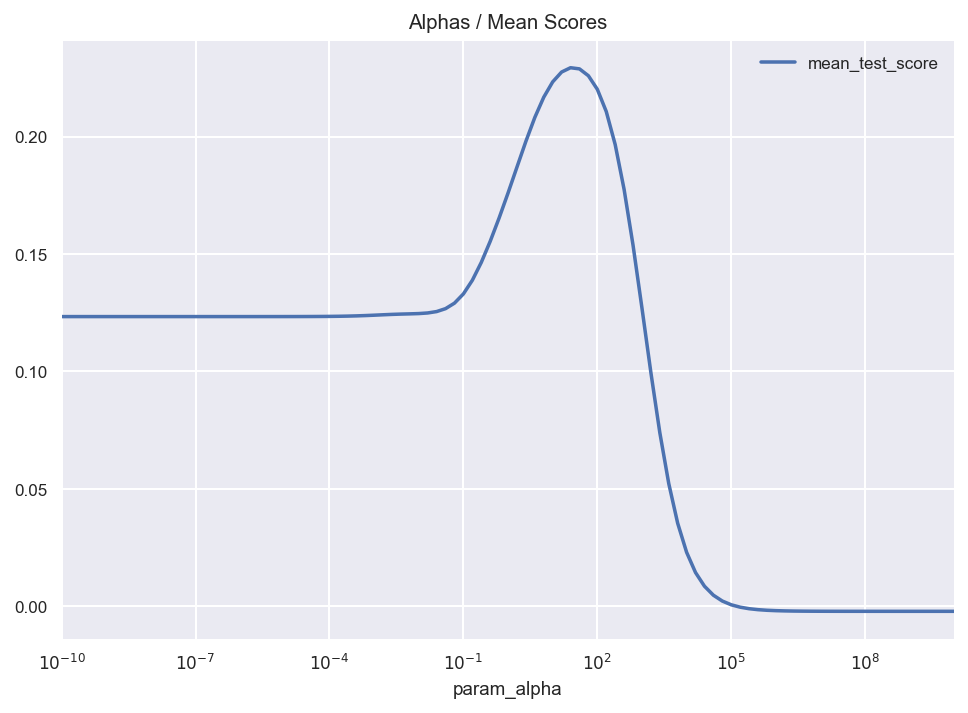

In [2891]:
df_score.plot( x="param_alpha", y="mean_test_score", title="Alphas / Mean Scores")
plt.xscale('log')
plt.show()

In [2892]:
coefs = []

for alpha in df_score.param_alpha:
    
    # Initialize Lasso model with alpha parameter
    ridge = Ridge(alpha=alpha)
    model = ridge.fit(Xnf_tr, y_train_res)
    
    # Append coeficients to new object for later review
    alpha_coefs_r = {key: value for key, value in zip(Xnf_tr.columns, model.coef_.flatten())}
    alpha_coefs_r.update({"alpha": alpha}) # include alpha in list
    
    coefs.append(alpha_coefs_r)

In [2893]:
print "Best Alpha was: ", results.best_params_

# Coefs change with parameter alpha
df_coef = pd.DataFrame([c.values() for c in coefs],columns=coefs[0].keys())

df_coef['alpha'] = df_coef['alpha'].round(3)
df_coef.set_index('alpha',inplace=True)
df_coef.head(10)

Best Alpha was:  {'alpha': 25.11886431509582}


,C(MasVnrType)[T.Stone],C(BsmtCond)[T.Gd],C(SaleType)[T.ConLw],C(RoofMatl)[T.Roll],C(Exterior2nd)[T.AsphShn],C(BsmtFinType1)[T.Unf],C(MiscFeature)[T.Othr],C(RoofStyle)[T.Mansard],C(BsmtCond)[T.None],C(GarageQual)[T.Gd],...,C(Functional)[T.Min2],C(FireplaceQu)[T.None],C(Exterior2nd)[T.MetalSd],C(ExterQual)[T.Gd],C(GarageFinish)[T.Unf],C(BsmtFinType2)[T.None],C(PavedDrive)[T.P],C(HeatingQC)[T.Fa],C(ExterCond)[T.TA],C(MiscFeature)[T.Shed]
alpha,,,,,,,,,,,,,,,,,,,,,
0.0,3839.058017,4293.239894,-4353.540614,-17114.546086,-19688.337957,1339.327070,47070.441805,18574.954932,28001.071288,-153953.578278,...,8013.806478,9638.434202,-8485.604151,-24289.307238,675.354112,-55806.753795,-3449.390007,-2108.838274,-8585.037152,17140.682404
0.0,3839.058016,4293.239894,-4353.540613,-17114.546083,-19688.337954,1339.327070,47070.441689,18574.954929,28000.801286,-153953.578172,...,8013.806479,9638.434203,-8485.604150,-24289.307237,675.354112,-55806.753789,-3449.390007,-2108.838274,-8585.037151,17140.682298
0.0,3839.058016,4293.239894,-4353.540612,-17114.546078,-19688.337951,1339.327071,47070.441505,18574.954925,28000.997858,-153953.578003,...,8013.806479,9638.434204,-8485.604148,-24289.307235,675.354113,-55806.753779,-3449.390006,-2108.838273,-8585.037149,17140.682131
0.0,3839.058015,4293.239893,-4353.540610,-17114.546071,-19688.337945,1339.327072,47070.441213,18574.954919,28000.963228,-153953.577735,...,8013.806480,9638.434206,-8485.604145,-24289.307233,675.354114,-55806.753764,-3449.390006,-2108.838273,-8585.037147,17140.681866
0.0,3839.058013,4293.239893,-4353.540607,-17114.546060,-19688.337935,1339.327074,47070.440751,18574.954909,28001.085519,-153953.577311,...,8013.806482,9638.434209,-8485.604141,-24289.307229,675.354116,-55806.753739,-3449.390006,-2108.838273,-8585.037143,17140.681445
0.0,3839.058010,4293.239893,-4353.540603,-17114.546042,-19688.337921,1339.327077,47070.440019,18574.954893,28001.176103,-153953.576638,...,8013.806485,9638.434214,-8485.604134,-24289.307222,675.354119,-55806.753700,-3449.390005,-2108.838273,-8585.037136,17140.680780
0.0,3839.058005,4293.239892,-4353.540596,-17114.546013,-19688.337897,1339.327082,47070.438858,18574.954867,28001.267828,-153953.575571,...,8013.806490,9638.434221,-8485.604123,-24289.307212,675.354124,-55806.753639,-3449.390003,-2108.838272,-8585.037126,17140.679724
0.0,3839.057998,4293.239892,-4353.540585,-17114.545968,-19688.337860,1339.327089,47070.437018,18574.954826,28001.216802,-153953.573882,...,8013.806497,9638.434234,-8485.604105,-24289.307195,675.354132,-55806.753541,-3449.390001,-2108.838271,-8585.037110,17140.678051
0.0,3839.057987,4293.239890,-4353.540568,-17114.545897,-19688.337802,1339.327101,47070.434102,18574.954762,28001.219911,-153953.571203,...,8013.806509,9638.434253,-8485.604077,-24289.307169,675.354144,-55806.753386,-3449.389998,-2108.838269,-8585.037085,17140.675400


In [2894]:
# df_coef.plot(title="Gridsearch Effect on Param Alpha")
# plt.xscale('log')
# plt.xlim([10**(0),10**(6)])
# plt.ylim([-50000,50000])
# plt.legend(loc=[1,0])
# plt.show()

In [2895]:
predictions_xnf_tr_sub = results.best_estimator_.predict(Xnf_tr)
predictions_xnf_te_sub = results.best_estimator_.predict(Xnf_te)

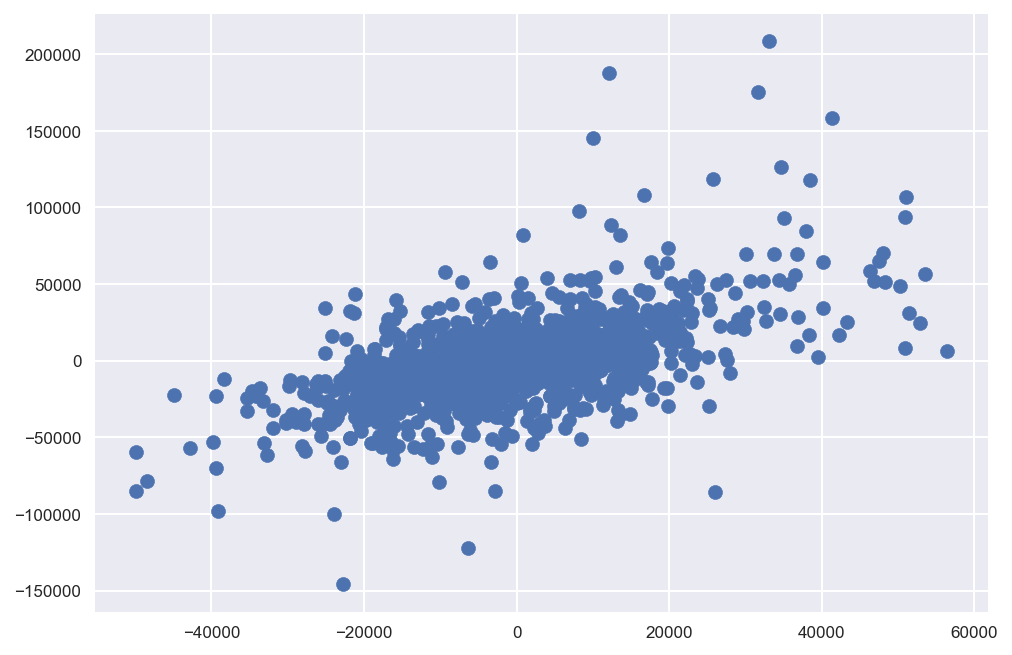

In [2896]:
plt.scatter(predictions_xnf_tr_sub, y_train_res)

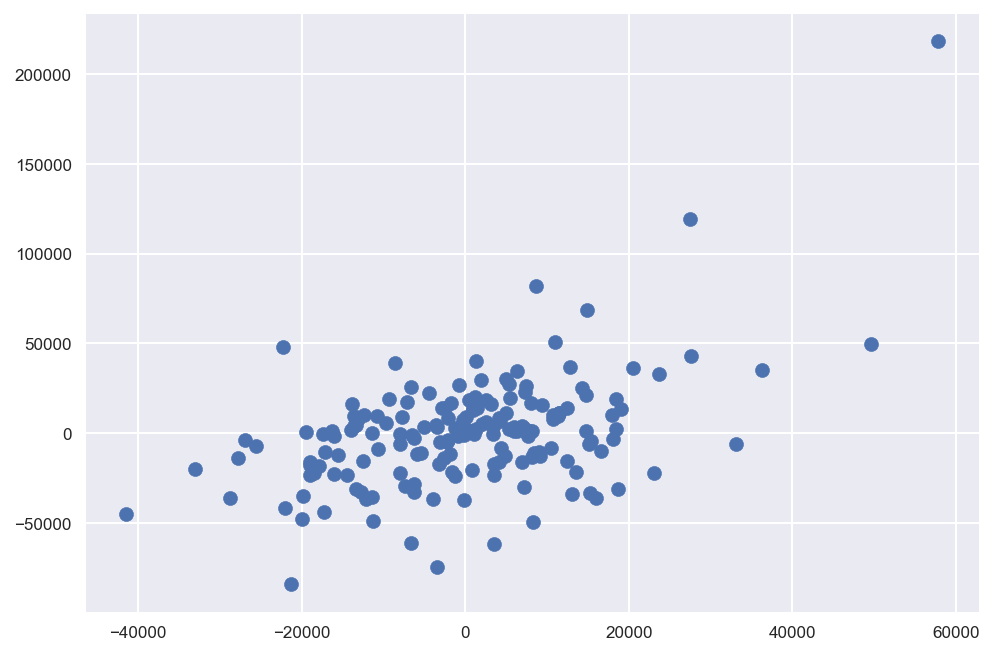

In [2897]:
plt.scatter(predictions_xnf_te_sub, y_test_res)
plt.show()

In [2898]:
print results.best_score_
print results.best_estimator_

0.229326434954
Ridge(alpha=25.11886431509582, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


Let's take a look at the coefficients we are working with:

In [2899]:
 for f, c in zip(Xnf_tr.columns, results.best_estimator_.coef_):
     print f, c

BsmtUnfSF -8590.21199826
C(BsmtCond)[T.Gd] 750.968717554
C(BsmtCond)[T.None] 3140.30952383
C(BsmtCond)[T.Po] 1490.08819105
C(BsmtCond)[T.TA] 3261.41911277
C(BsmtFinType1)[T.BLQ] 323.374647953
C(BsmtFinType1)[T.GLQ] 3357.83243339
C(BsmtFinType1)[T.LwQ] -5216.85652733
C(BsmtFinType1)[T.None] 3140.30952383
C(BsmtFinType1)[T.Rec] -635.712499362
C(BsmtFinType1)[T.Unf] 98.3945565812
C(BsmtFinType2)[T.BLQ] -2326.69904133
C(BsmtFinType2)[T.GLQ] 1182.6680955
C(BsmtFinType2)[T.LwQ] -4090.92537169
C(BsmtFinType2)[T.None] 1227.75752379
C(BsmtFinType2)[T.Rec] -2983.82441703
C(BsmtFinType2)[T.Unf] 441.973207982
C(CentralAir)[T.Y] 585.314080053
C(Electrical)[T.FuseF] 1181.66301718
C(Electrical)[T.FuseP] -1156.25869613
C(Electrical)[T.Mix] 449.731405989
C(Electrical)[T.SBrkr] -3553.87769872
C(ExterCond)[T.Fa] 687.747547356
C(ExterCond)[T.Gd] -2356.89799166
C(ExterCond)[T.Po] 0.0
C(ExterCond)[T.TA] 519.328999665
C(ExterQual)[T.Fa] 225.904925593
C(ExterQual)[T.Gd] -10232.538937
C(ExterQual)[T.TA] -8258.

The low-ish score for the model of 0.22 makes some sense as much of the variance in the residuals will be explained by the fixed features not taken account in the subset in the model we used to calculate our residuals. So about 22% of that can be explained by non-fixed or renovatable features. Let's look at each individually:

In [2900]:
print df.OverallQual.describe()
print df.OverallCond.describe()

count    1446.000000
mean        6.103734
std         1.359432
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64
count    1446.000000
mean        5.582988
std         1.108489
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64


### Recommendations:

What we can surmise from this model is that for each improvement of 1.35 points on the 1-10 scale of Overall Quality we will see an increase in price of 9276 and an increase of 5402 for an increase in approximately 1 point on the 1-10 scale of Overall Condition. Thus Overall Quality is more important than Overall Condition, whilst the two you would assume to share some correlation, they do not:

In [2901]:
df[['OverallCond','OverallQual']].corr()

,OverallCond,OverallQual
OverallCond,1.00000,-0.10675
OverallQual,-0.10675,1.00000


In [3231]:
df.BsmtUnfSF.describe()

count    1446.000000
mean      567.124481
std       442.919012
min         0.000000
25%       221.500000
50%       475.000000
75%       807.500000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

Basement Condition doesn't matter as much as Unfinished Square Footage in the Basement, for every 440 square feet of unfinished basement there is a loss of 8590, renovate if under this cost.

Use Brick Face for exteriors if it costs less than 9000 to renovate. 

Upgrade the roof to Mansard if it costs under 1710 to do.

Upgrade the kitchen quality to excellent, you lose almost 10000 by having an average quality kitchen.

### Predicting an Abnormal Sale:

We are trying to calculate whether a sale will be abnormal or not and this requires a logistic regression. We know that abnormal sales occur as a result of short sales or foreclosures, we can assume that our accuracy can only be so high with the data we have, for example, abnormal sales due to an owner's death cannot be accounted for with the data set we have but there may possibly be a correlation to Year Built. We can maybe assume that the newer the remodeling date for the house the less the chance of an abnormal sale. There are a lot of factors involved in this but we will try to tackle it logically.

Since we are working with a binary outcome, abnormal or not, we will use the feature that was already set up in our Xfix_tr set and drop the other SaleConditions features.

Combining our standardized features into a single dataframe:

In [3254]:
dfabtr = Xfix_tr.combine_first(Xnf_tr)

In [3255]:
dfabte = Xfix_te.combine_first(Xnf_te)

In [3256]:
dfab = dfabtr.append(dfabte, ignore_index=True, verify_integrity=False)

In [3257]:
dfab.columns.tolist()

['BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'C(Alley)[T.None]',
 'C(Alley)[T.Pave]',
 'C(BldgType)[T.2fmCon]',
 'C(BldgType)[T.Duplex]',
 'C(BldgType)[T.TwnhsE]',
 'C(BldgType)[T.Twnhs]',
 'C(BsmtCond)[T.Gd]',
 'C(BsmtCond)[T.None]',
 'C(BsmtCond)[T.Po]',
 'C(BsmtCond)[T.TA]',
 'C(BsmtExposure)[T.Gd]',
 'C(BsmtExposure)[T.Mn]',
 'C(BsmtExposure)[T.No]',
 'C(BsmtExposure)[T.None]',
 'C(BsmtFinType1)[T.BLQ]',
 'C(BsmtFinType1)[T.GLQ]',
 'C(BsmtFinType1)[T.LwQ]',
 'C(BsmtFinType1)[T.None]',
 'C(BsmtFinType1)[T.Rec]',
 'C(BsmtFinType1)[T.Unf]',
 'C(BsmtFinType2)[T.BLQ]',
 'C(BsmtFinType2)[T.GLQ]',
 'C(BsmtFinType2)[T.LwQ]',
 'C(BsmtFinType2)[T.None]',
 'C(BsmtFinType2)[T.Rec]',
 'C(BsmtFinType2)[T.Unf]',
 'C(BsmtQual)[T.Fa]',
 'C(BsmtQual)[T.Gd]',
 'C(BsmtQual)[T.None]',
 'C(BsmtQual)[T.TA]',
 'C(CentralAir)[T.Y]',
 'C(Condition1)[T.Feedr]',
 'C(Condition1)[T.Norm]',
 'C(Condition1)[T.PosA]',
 'C(Condition1)[T.PosN]',
 'C(Condition1)[T.RR

We will get rid of all Sale related features as they will be irrelevant in predicting an Abnormal Sale, i.e if it is an Abnormal Sale, the Sale Type might normally be not be typical and the Sale Price will also probably be abnormal. Either way we are predicting the Sale on other predictors not on interrelated features.

In [3258]:
dfab.drop(['C(SaleCondition)[AdjLand]','C(SaleCondition)[Alloca]','C(SaleCondition)[Family]','C(SaleCondition)[Normal]',
 'C(SaleCondition)[Partial]',  'C(SaleType)[T.CWD]',
 'C(SaleType)[T.ConLD]',
 'C(SaleType)[T.ConLI]',
 'C(SaleType)[T.ConLw]',
 'C(SaleType)[T.Con]',
 'C(SaleType)[T.New]',
 'C(SaleType)[T.Oth]',
 'C(SaleType)[T.WD]'], axis=1, inplace=True )

In [3259]:
# dfab_te.drop(['C(SaleCondition)[AdjLand]','C(SaleCondition)[Alloca]','C(SaleCondition)[Family]','C(SaleCondition)[Normal]',
#  'C(SaleCondition)[Partial]'], axis=1, inplace=True )

Set the target and drop it from our dataframe.

In [3260]:
y_ab = dfab['C(SaleCondition)[Abnorml]']

In [3261]:
y_ab.value_counts()

0.0    1351
1.0      95
Name: C(SaleCondition)[Abnorml], dtype: int64

Let's run a correlation matrix to see the top 20 positive and negative features first.

In [3262]:
dfab.corr()['C(SaleCondition)[Abnorml]'].sort_values(ascending=False)[0:20]

C(SaleCondition)[Abnorml]    1.000000
C(Exterior1st)[T.Stone]      0.140345
C(MSZoning)[T.RH]            0.105370
C(Utilities)[NoSeWa]         0.099205
C(Electrical)[T.Mix]         0.099205
C(Functional)[T.Sev]         0.099205
C(BsmtQual)[T.TA]            0.095657
C(FireplaceQu)[T.None]       0.090924
C(ExterQual)[T.TA]           0.085975
C(GarageFinish)[T.None]      0.083641
C(GarageCond)[T.None]        0.083641
C(GarageQual)[T.None]        0.083641
C(GarageType)[T.None]        0.083641
C(HeatingQC)[T.TA]           0.075827
C(Foundation)[T.CBlock]      0.072136
C(GarageType)[T.Basment]     0.070930
EnclosedPorch                0.068549
C(Exterior1st)[T.BrkComm]    0.065238
C(BsmtCond)[T.Po]            0.065238
C(Neighborhood)[T.NAmes]     0.063283
Name: C(SaleCondition)[Abnorml], dtype: float64

In [3263]:
dfab.corr()['C(SaleCondition)[Abnorml]'].sort_values(ascending=True)[0:20]

YearRemodAdd                       -0.124895
GarageYrBlt                        -0.116118
GarageCars                         -0.101706
C(Utilities)[AllPub]               -0.099205
YearBuilt                          -0.095981
OverallQual                        -0.090611
GarageArea                         -0.089812
C(FireplaceQu)[T.Gd]               -0.087539
C(GarageQual)[T.TA]                -0.086292
FullBath                           -0.085976
C(Foundation)[T.PConc]             -0.085628
Fireplaces                         -0.084679
C(GarageCond)[T.TA]                -0.081625
C(GarageType)[T.Attchd]            -0.079530
C(MSSubClass)[T.TwoStory1946New]   -0.071907
C(BsmtQual)[T.Gd]                  -0.071105
C(ExterQual)[T.Gd]                 -0.070845
C(Fence)[T.None]                   -0.069522
C(Neighborhood)[T.NridgHt]         -0.062889
C(Neighborhood)[T.CollgCr]         -0.062751
Name: C(SaleCondition)[Abnorml], dtype: float64

Year remodeled is a negative predictor of an Abnormal sale, followed by Garage Year Built and houses which have all Utilities and the number of cars in the Garage. Whilst on the positive side,  abnormal sales occur more often in high density residential areas, with houses with no water tanks, houses with stone exteriors which I would associate with high density residential areas such as projects. Houses with poor functionality - i.e. severly damaged and with mixed Electrical features tend to also correlate a little with Abnormal sales. These features make sense as they are all indicators of poor socio economic neighborhood and would tend to correlate with abnormal sales.

In [3264]:
dfab.drop('C(SaleCondition)[Abnorml]', axis=1, inplace=True)

What is our baseline accuracy for predicting Abnormal Sales in our training and test sets:

In [3265]:
print "Baseline Accuracy Train", 1 - y_ab.mean()

Baseline Accuracy Train 0.934301521438


Let's run a logistic regression on all the features and then work down from there:

In [3266]:
from sklearn.linear_model import LogisticRegression
X = dfab
print "Baseline: ", 1 - y_ab.mean()

model = LogisticRegression() 

model.fit(X, y_ab) 
print "Model accuracy:", model.score(X,y_ab)

Baseline:  0.934301521438
Model accuracy: 0.9377593361


Using all non sale related features the logistic regression model is only slightly more accurate than the baseline accuracy.

In [3267]:
def examine_coefficients(model, df):
    df = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')
    return df

coefdf_ab = examine_coefficients(model, X)

In [3268]:
coefdf_ab.head()

,Coefficient,Feature
147,-1.423934,C(KitchenQual)[T.Fa]
201,-0.985015,C(Neighborhood)[T.NridgHt]
97,-0.942941,C(FireplaceQu)[T.Gd]
79,-0.915152,C(Exterior2nd)[T.BrkFace]
90,-0.870174,C(Exterior2nd)[T.Wd Sdng]


In [3269]:
print coefdf_ab.head(20)

     Coefficient                     Feature
147    -1.423934        C(KitchenQual)[T.Fa]
201    -0.985015  C(Neighborhood)[T.NridgHt]
97     -0.942941        C(FireplaceQu)[T.Gd]
79     -0.915152   C(Exterior2nd)[T.BrkFace]
90     -0.870174   C(Exterior2nd)[T.Wd Sdng]
150    -0.846056       C(LandContour)[T.HLS]
210    -0.808619          C(PavedDrive)[T.P]
9      -0.804213       C(BldgType)[T.Duplex]
180    -0.791900       C(MasVnrType)[T.None]
16     -0.775104       C(BsmtExposure)[T.Gd]
125    -0.727418     C(GarageType)[T.Attchd]
20     -0.724152      C(BsmtFinType1)[T.BLQ]
243    -0.706399                     MiscVal
190    -0.699605  C(Neighborhood)[T.CollgCr]
156    -0.683324         C(LotConfig)[T.FR2]
178    -0.657146           C(MSZoning)[T.RM]
137    -0.633135          C(HeatingQC)[T.Gd]
140    -0.631931     C(HouseStyle)[T.1.5Unf]
181    -0.629599      C(MasVnrType)[T.Stone]
40     -0.619358       C(Condition1)[T.PosN]


In [3270]:
print coefdf_ab.tail(20)

     Coefficient                     Feature
54      0.465008        C(Electrical)[T.Mix]
11      0.469094        C(BldgType)[T.Twnhs]
208     0.476905   C(Neighborhood)[T.Timber]
74      0.496413   C(Exterior1st)[T.VinylSd]
197     0.517216    C(Neighborhood)[T.NAmes]
17      0.517361       C(BsmtExposure)[T.Mn]
7       0.521709            C(Alley)[T.Pave]
151     0.548318       C(LandContour)[T.Low]
154     0.548814         C(LandSlope)[T.Sev]
200     0.576051  C(Neighborhood)[T.NoRidge]
189     0.599883  C(Neighborhood)[T.ClearCr]
110     0.603697        C(Functional)[T.Sev]
128     0.607920    C(GarageType)[T.CarPort]
199     0.705280   C(Neighborhood)[T.NWAmes]
64      0.715676   C(Exterior1st)[T.BrkComm]
91      0.728323   C(Exterior2nd)[T.Wd Shng]
187     0.729141   C(Neighborhood)[T.BrDale]
176     0.782698           C(MSZoning)[T.RH]
41      0.938983       C(Condition1)[T.RRAe]
72      1.112141     C(Exterior1st)[T.Stone]


In [3271]:
y_ab.value_counts()

0.0    1351
1.0      95
Name: C(SaleCondition)[Abnorml], dtype: int64

In [3272]:
np.random.seed(10)

remove_n = 485

df = y_train[y_train == 0]
drop_indices = np.random.choice(df.index, remove_n, replace=False)

y_train = y_train.drop(drop_indices)
print y_train.shape

X_train = X_train.drop(drop_indices)
print X_train.shape

ValueError: Cannot take a larger sample than population when 'replace=False'

In [3250]:
top20 = coefdf_ab['Feature'][0:20].tolist()

In [3251]:
low20 = coefdf_ab['Feature'][-20:].tolist()

In [3205]:
top40coef = top20+low20

Create a Train and Test split with Stratify to account for the correct proportions:

In [3215]:
X_train, X_test, y_train, y_test = train_test_split(dfab, y_ab, test_size=0.3, random_state=42, stratify=y_ab)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(1012, 272) (1012,)
(434, 272) (434,)


In [3216]:
y_train.value_counts()

0.0    946
1.0     66
Name: C(SaleCondition)[Abnorml], dtype: int64

In [3217]:
76./(1080+76)

0.0657439446366782

In [3218]:
y_test.value_counts()

0.0    405
1.0     29
Name: C(SaleCondition)[Abnorml], dtype: int64

In [3219]:
19./(271+19)

0.06551724137931035

In [3229]:
from sklearn.linear_model import LogisticRegression
X = X_train[top40coef]
print "Baseline: ", 1 - y_ab.mean()

model = LogisticRegression() 

model.fit(X, y_train)
print cross_val_score(estimator.best_estimator_,X_test[top40coef],y_test,cv=5).mean()
print classification_report(y_test,cross_val_predict(model,X_test[top40coef],y_test,cv=5))

Baseline:  0.934301521438
0.93319967923
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.97       405
        1.0       0.00      0.00      0.00        29

avg / total       0.87      0.93      0.90       434



Unfortunately it seems that without Sales related features, the model is useless at predicting abnormal sales, which tells me that it is almost a futile process to try to predict Abnormal sales when the terms of said sale is the best predictor of an Abnormal Sale. Let's try adding the Sales Features back in and compare:

In [3221]:
dfabtr = Xfix_tr.combine_first(Xnf_tr)

In [3213]:
dfabte = Xfix_te.combine_first(Xnf_te)

In [3214]:
dfab = dfabtr.append(dfabte, ignore_index=True, verify_integrity=False)

In [3222]:
X_train, X_test, y_train, y_test = train_test_split(dfab, y_ab, test_size=0.3, random_state=42, stratify=y_ab)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(1012, 272) (1012,)
(434, 272) (434,)


In [3223]:
model = LogisticRegression() 

params = {'penalty': ['l1','l2'],
          'C': np.logspace(-10,10,21)}

estimator = GridSearchCV(model,param_grid=params,cv=5)
estimator.fit(X_train,y_train)
estimator.best_estimator_

LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [3228]:
print cross_val_score(estimator.best_estimator_,X_test,y_test,cv=5).mean()
print classification_report(y_test,cross_val_predict(estimator.best_estimator_,X_test,y_test,cv=5))

0.979310344828
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99       405
        1.0       0.95      0.72      0.82        29

avg / total       0.98      0.98      0.98       434



As you can see the logistic regression improves on the baseline decently but from the client's standpoint, is there any value in predicting Abnormality based on the sales condition and price of an Abnormal Sale, these are the inherent characteristics of an Abnormal Sale not a true predictor.

Ordinarily to handle class imbalance we would have to either overrepresent our target by undersampling or upsampling and try to model from there but in this case I would argue against it as our logistic regressions without any Sales features have already proven very weak predictors of Abnormal sales, the difference between the regressions with and without is massive and as such we can assume that even with adjusting we will not be able to improve upon our baseline accuracy. 